In [1]:
%cd "../.."

/home/ensai/projet-statistique-2022


In [2]:
from gensim import models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import json
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.manifold import TSNE

import seaborn as sns
import plotly.express as px


from word_embedding.distance_wmd import *
import doc_embedding.moyenne as moyenne
from reduction_dim.correlation_matrix import *
import clustering.fit_clustering as CL 

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
with open('data/docs.json', encoding = "utf8") as f:
    docs = json.load(f)

dict_moy_embedding = {}
for modele in ["glove","cbow","skipgram"]:
    ev = models.KeyedVectors.load_word2vec_format(f"data/tunning/{modele}.kv")
    #Read moy matrix
    dict_moy_embedding[modele] = {}
    dict_moy_embedding[modele]["TF"] = moyenne.word_emb_vers_doc_emb_moyenne(docs, ev, methode = 'TF')
    dict_moy_embedding[modele]["TFIDF"] = moyenne.word_emb_vers_doc_emb_moyenne(docs, ev, methode = 'TF-IDF')

In [4]:
dict_wmd_embedding = {}
for modele in ["glove","cbow","skipgram"]:
    #Read moy matrix
    dict_wmd_embedding[modele] = {}
    dict_wmd_embedding[modele]["Distance"] = np.array(lecture_fichier_distances_wmd(f"distances_{modele}.7z"))
    if modele != "glove":
        dict_wmd_embedding[modele]["MDS"] = np.array(pd.read_csv(f"data/tunning/MDS/{modele}_mds_embedding.csv",sep=";",header=0))

In [17]:
df_kmeans_clustering = pd.read_csv("data/tunning/clustering/kmeans.csv",sep=";")
df_kmeans_clustering.head()

K initialisation  nb_iter  tolerance      val_obj  silhouette  \
0  2      k-means++     10.0     0.0001  1293.257039    0.550733   
1  2         random     10.0     0.0001  1293.257039    0.550733   
2  3      k-means++     10.0     0.0001   958.649395    0.294544   
3  3         random     10.0     0.0001   958.649395    0.294544   
4  4      k-means++     10.0     0.0001   779.570831    0.294610   

   Cal-Harabasz      DBCV clustering  perplexity wordEmbedding docEmbedding  \
0   5672.310806 -0.768834     kmeans         NaN      skipgram      Moyenne   
1   5672.310806 -0.768834     kmeans         NaN      skipgram      Moyenne   
2   5483.281495 -0.871607     kmeans         NaN      skipgram      Moyenne   
3   5483.281495 -0.871607     kmeans         NaN      skipgram      Moyenne   
4   5222.015682 -0.827194     kmeans         NaN      skipgram      Moyenne   

  docEmbedding2  
0            TF  
1            TF  
2            TF  
3            TF  
4            TF

# Avant Tsne

## Moyenne embedding

In [19]:
df_kmeans_moy = df_kmeans_clustering.loc[(df_kmeans_clustering["docEmbedding"] == "Moyenne") & (df_kmeans_clustering["perplexity"].isna())].reset_index()

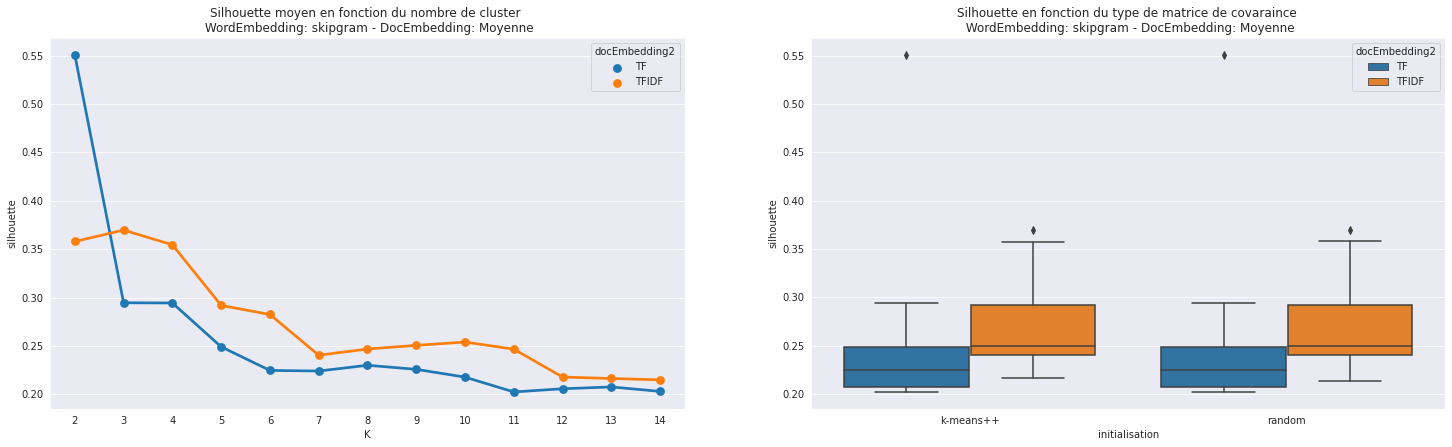

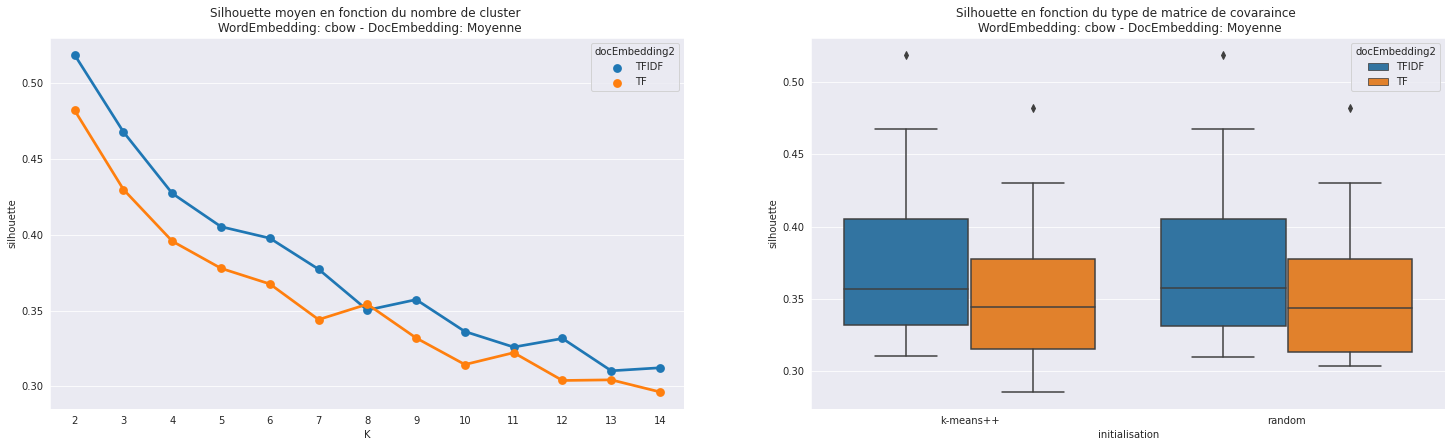

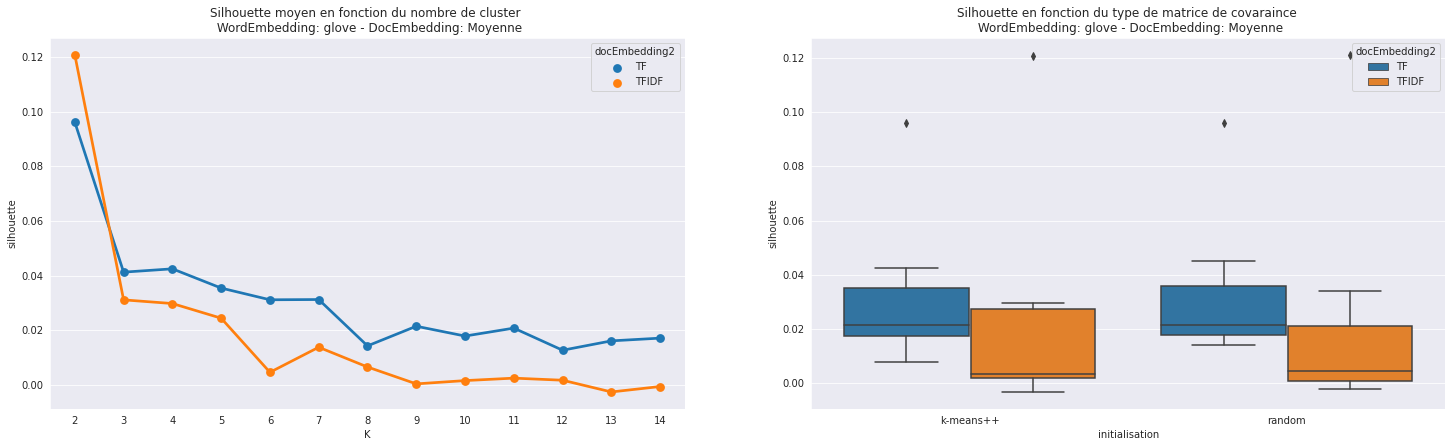

In [33]:
sns.set_style("darkgrid")
for modele in ["skipgram","cbow","glove"]:
    plt.figure(figsize = (25,15))
    sns.pointplot(data=df_kmeans_moy[df_kmeans_moy["wordEmbedding"]==modele],y="silhouette",x="K",hue="docEmbedding2",ci=None,
        ax=plt.subplot(2,2,1,title=f"Silhouette moyen en fonction du nombre de cluster \n WordEmbedding: {modele} - DocEmbedding: Moyenne"))
    # sns.boxplot(data = df_kmeans_moy[df_kmeans_moy["wordEmbedding"]==modele],y="silhouette",x="K",hue="docEmbedding2",ax=plt.subplot(2,2,1,title="K"))

    sns.boxplot(data=df_kmeans_moy[df_kmeans_moy["wordEmbedding"]==modele],y="silhouette",x="initialisation",hue="docEmbedding2",
        ax=plt.subplot(2,2,2,title=f"Silhouette en fonction du type de matrice de covaraince \n WordEmbedding: {modele} - DocEmbedding: Moyenne"))
    # sns.boxplot(data=df_kmeans_moyTF,y="silhouette",x="initialisation",hue="wordEmbedding",ax=plt.subplot(2,2,2,title="initialisation"))
    plt.show()

In [21]:
df_kmeans_moy.loc[df_kmeans_moy.groupby(["wordEmbedding"])["silhouette"].idxmax()]

index  K initialisation  nb_iter  tolerance      val_obj  silhouette  \
43     199  2         random     10.0     0.0001  1183.081300    0.518736   
104   1118  2         random     10.0     0.0001     0.461005    0.121071   
0        0  2      k-means++     10.0     0.0001  1293.257039    0.550733   

     Cal-Harabasz      DBCV clustering  perplexity wordEmbedding docEmbedding  \
43   14238.411443 -0.789848     kmeans         NaN          cbow      Moyenne   
104    144.477072 -0.614859     kmeans         NaN         glove      Moyenne   
0     5672.310806 -0.768834     kmeans         NaN      skipgram      Moyenne   

    docEmbedding2  
43          TFIDF  
104         TFIDF  
0              TF

## WMD

In [22]:
df_kmeans_wmd = df_kmeans_clustering.loc[(df_kmeans_clustering["docEmbedding"] == "WMD") & (df_kmeans_clustering["perplexity"].isna())].reset_index()

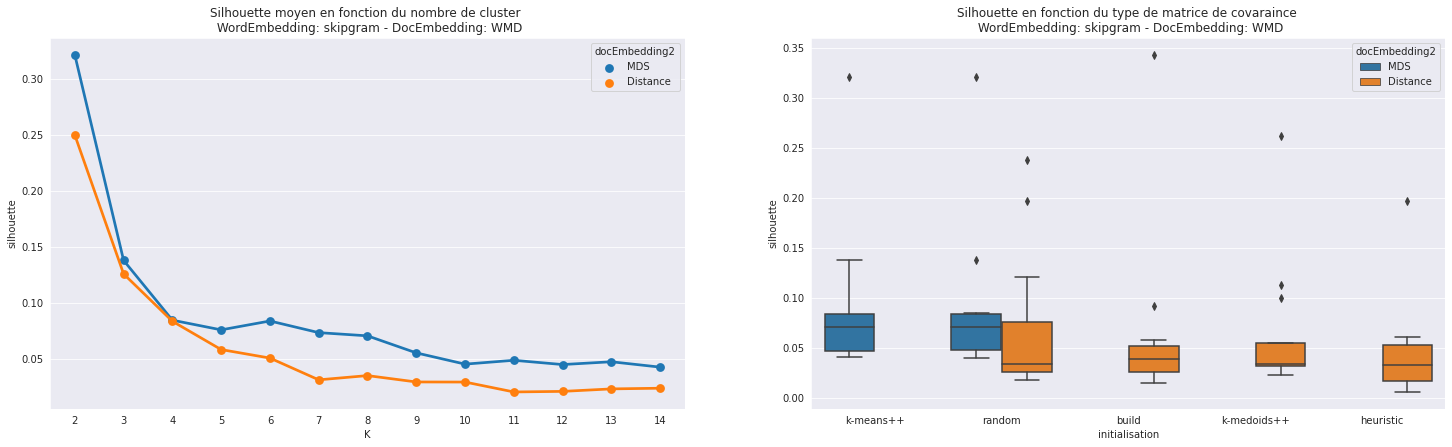

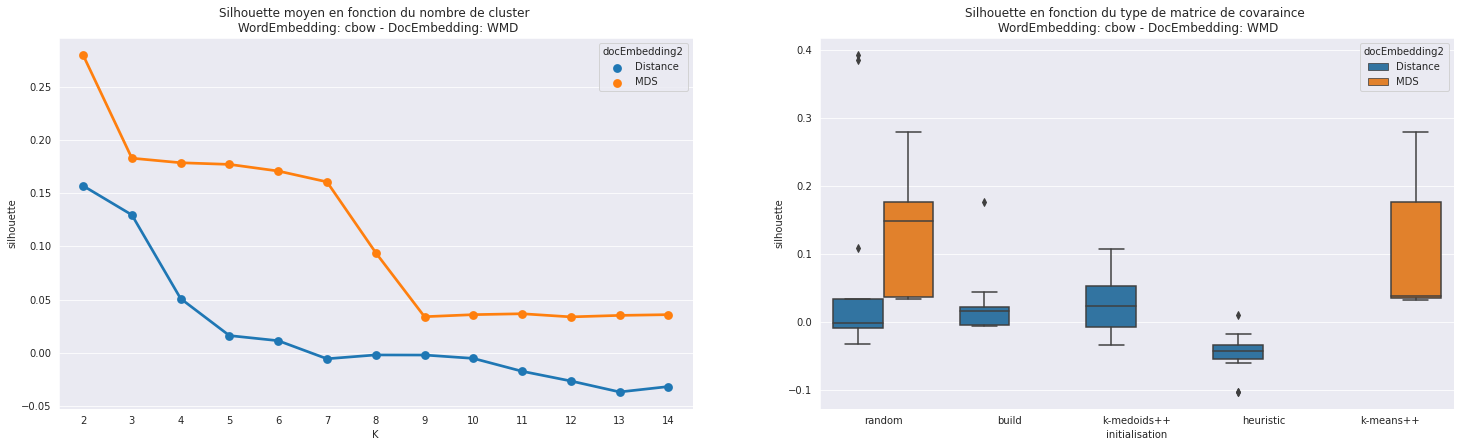

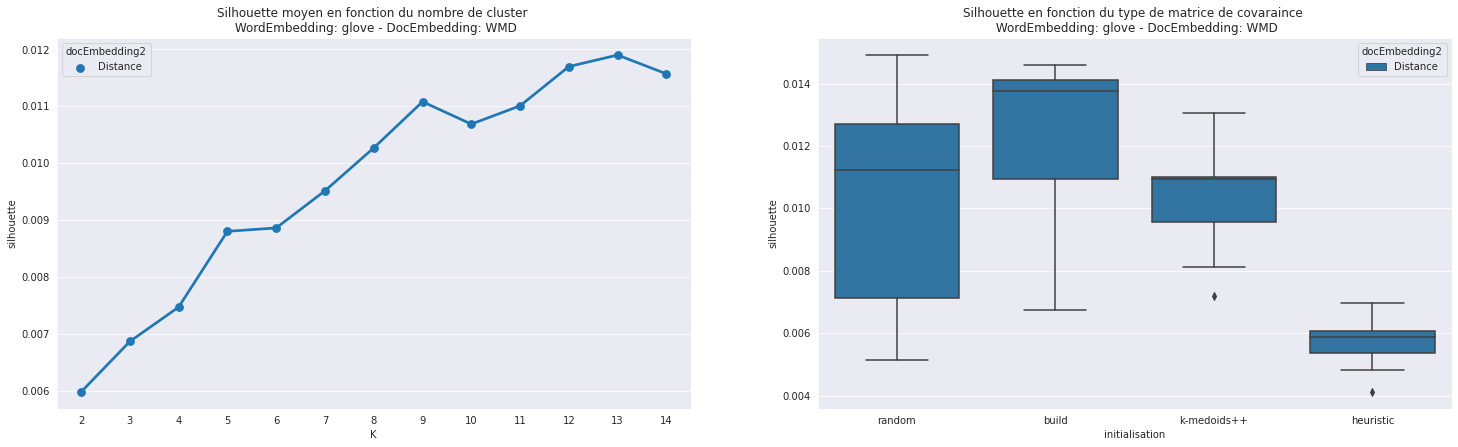

In [34]:
sns.set_style("darkgrid")
for modele in ["skipgram","cbow","glove"]:
    plt.figure(figsize = (25,15))
    sns.pointplot(data=df_kmeans_wmd[df_kmeans_wmd["wordEmbedding"]==modele],y="silhouette",x="K",hue="docEmbedding2",ci=None,
        ax=plt.subplot(2,2,1,title=f"Silhouette moyen en fonction du nombre de cluster \n WordEmbedding: {modele} - DocEmbedding: WMD"))
    # sns.boxplot(data = df_kmeans_moy[df_kmeans_moy["wordEmbedding"]==modele],y="silhouette",x="K",hue="docEmbedding2",ax=plt.subplot(2,2,1,title="K"))

    sns.boxplot(data=df_kmeans_wmd[df_kmeans_wmd["wordEmbedding"]==modele],y="silhouette",x="initialisation",hue="docEmbedding2",
        ax=plt.subplot(2,2,2,title=f"Silhouette en fonction du type de matrice de covaraince \n WordEmbedding: {modele} - DocEmbedding: WMD"))
    # sns.boxplot(data=df_kmeans_moyTF,y="silhouette",x="initialisation",hue="wordEmbedding",ax=plt.subplot(2,2,2,title="initialisation"))
    plt.show()

In [37]:
df_kmeans_wmd.loc[df_kmeans_wmd.groupby(["wordEmbedding","docEmbedding2"])["silhouette"].idxmax()]

index   K initialisation  nb_iter  tolerance       val_obj  silhouette  \
0      364   2         random      NaN        NaN  1.854196e+06    0.393266   
131   1691   2         random     10.0     0.0001  3.888807e+08    0.280042   
156   1872  12         random      NaN        NaN  1.142444e+07    0.014913   
78    1482   2          build      NaN        NaN  1.983063e+06    0.342656   
52     754   2      k-means++     10.0     0.0001  3.936005e+08    0.321155   

     Cal-Harabasz      DBCV clustering  perplexity wordEmbedding docEmbedding  \
0             NaN -0.582591  kmedoides         NaN          cbow          WMD   
131   1208.093956 -0.612498     kmeans         NaN          cbow          WMD   
156           NaN       NaN  kmedoides         NaN         glove          WMD   
78            NaN -0.894603  kmedoides         NaN      skipgram          WMD   
52    2623.537959 -0.715851     kmeans         NaN      skipgram          WMD   

    docEmbedding2  
0        Distance  
131           MDS  
156      Distance  
78       Distance  
52            MDS

# Avec TSNE

## Moyenne

In [38]:
df_kmeans_moy2 = df_kmeans_clustering.loc[(df_kmeans_clustering["docEmbedding"] == "Moyenne") & (df_kmeans_clustering["perplexity"].notna())].reset_index()

In [39]:
df_kmeans_moy2.loc[df_kmeans_moy2.groupby(["wordEmbedding","docEmbedding"])["silhouette"].idxmax()]

index  K initialisation  nb_iter  tolerance     val_obj  silhouette  \
308    360  3      k-means++     10.0     0.0001  2196685.50    0.509497   
415    701  2      k-means++     10.0     0.0001  2220466.00    0.376849   
620   1114  2         random     10.0     0.0001  2966657.75    0.491937   

     Cal-Harabasz      DBCV clustering  perplexity wordEmbedding docEmbedding  \
308  14295.322045 -0.663063     kmeans       200.0          cbow      Moyenne   
415   7089.565986 -0.874257     kmeans       125.0         glove      Moyenne   
620  13133.571780 -0.757427     kmeans       200.0      skipgram      Moyenne   

    docEmbedding2  
308         TFIDF  
415            TF  
620         TFIDF

## WMD

In [40]:
df_kmeans_wmd2 = df_kmeans_clustering.loc[(df_kmeans_clustering["docEmbedding"] == "WMD") & (df_kmeans_clustering["perplexity"].notna())].reset_index()

In [41]:
df_kmeans_wmd2.loc[df_kmeans_wmd2.groupby(["wordEmbedding","docEmbedding"])["silhouette"].idxmax()]

index  K initialisation  nb_iter  tolerance      val_obj  silhouette  \
46     462  3      k-means++     10.0     0.0001  5609326.000    0.420430   
776   2076  3      k-means++     10.0     0.0001  1957373.375    0.395142   
209    833  2      k-means++     10.0     0.0001  2546803.250    0.467745   

     Cal-Harabasz      DBCV clustering  perplexity wordEmbedding docEmbedding  \
46    8974.114765 -0.858434     kmeans        75.0          cbow          WMD   
776   8052.595624 -0.847480     kmeans       200.0         glove          WMD   
209  12305.542778 -0.753853     kmeans       100.0      skipgram          WMD   

    docEmbedding2  
46       Distance  
776      Distance  
209           MDS

# Plot ScatterPlot

In [43]:
def plot_kmeans(df_kmeans,dict_embedding,kmeans_metric="silhouette",first_reduce=False,modele="cbow"):
    best_model = df_kmeans.loc[df_kmeans.groupby(["wordEmbedding"])[kmeans_metric].idxmin()] if kmeans_metric == "BIC" else df_kmeans.loc[df_kmeans.groupby(["wordEmbedding"])[kmeans_metric].idxmax()]
    best_model = best_model[best_model["wordEmbedding"]==modele]

    if len(best_model) > 0:
        tsne_metric = "precomputed" if best_model["docEmbedding2"].values[0] == "Distance" else "euclidean"


        doc_embedding = dict_embedding[modele]

        tsne = TSNE(n_components = 2, perplexity=200, n_iter=2000, random_state=0,metric=tsne_metric)

        tsne_embedding = tsne.fit_transform(doc_embedding[best_model["docEmbedding2"].values[0]])

        if best_model["clustering"].values[0] == "kmeans":
            clust_model = KMeans(n_clusters = best_model["K"].values[0], init = best_model["initialisation"].values[0])
        else:
            clust_model = KMedoids(n_clusters = best_model["K"].values[0], init = best_model["initialisation"].values[0], metric = 'precomputed')
        
        kmeans_data = tsne_embedding if first_reduce else doc_embedding[best_model["docEmbedding2"].values[0]]
        labels = clust_model.fit_predict(kmeans_data)

        color_palette = sns.color_palette('Paired', len(np.unique(labels)))
        cluster_colors = [color_palette[x] for x in labels]

        title = f"Best Doc embedding kmeans Clustering based on {kmeans_metric}"
        subtitle1 = f"WordEmbedding: {modele} - Origin: {best_model['docEmbedding'].values[0]} {best_model['docEmbedding2'].values[0]} - First Reduce: {first_reduce} - Number of cluster: {len(np.unique(labels))}"
        subtitle2 = f"Silhouette: {round(best_model['silhouette'].values[0],2)}"
        title=f"{title}\n{subtitle1}\n{subtitle2}"


        return labels,tsne_embedding, cluster_colors, title
    else: 
        return [None, None,None,None]

## Moyenne Embedding

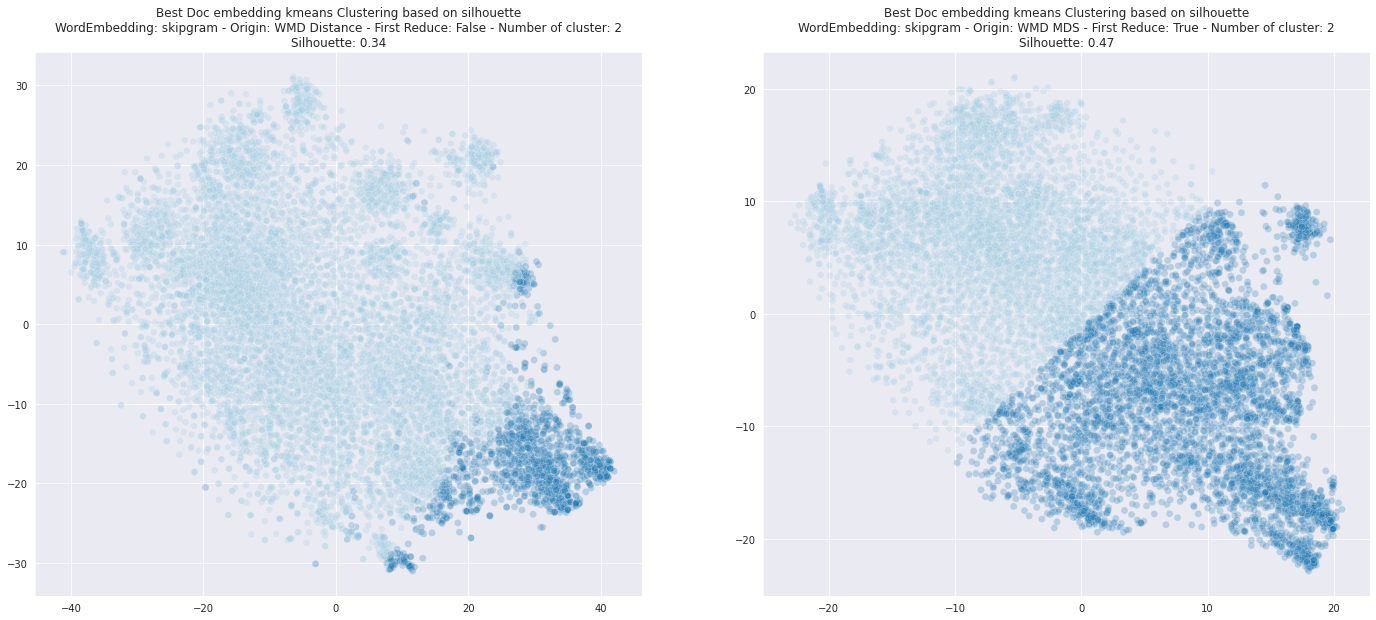

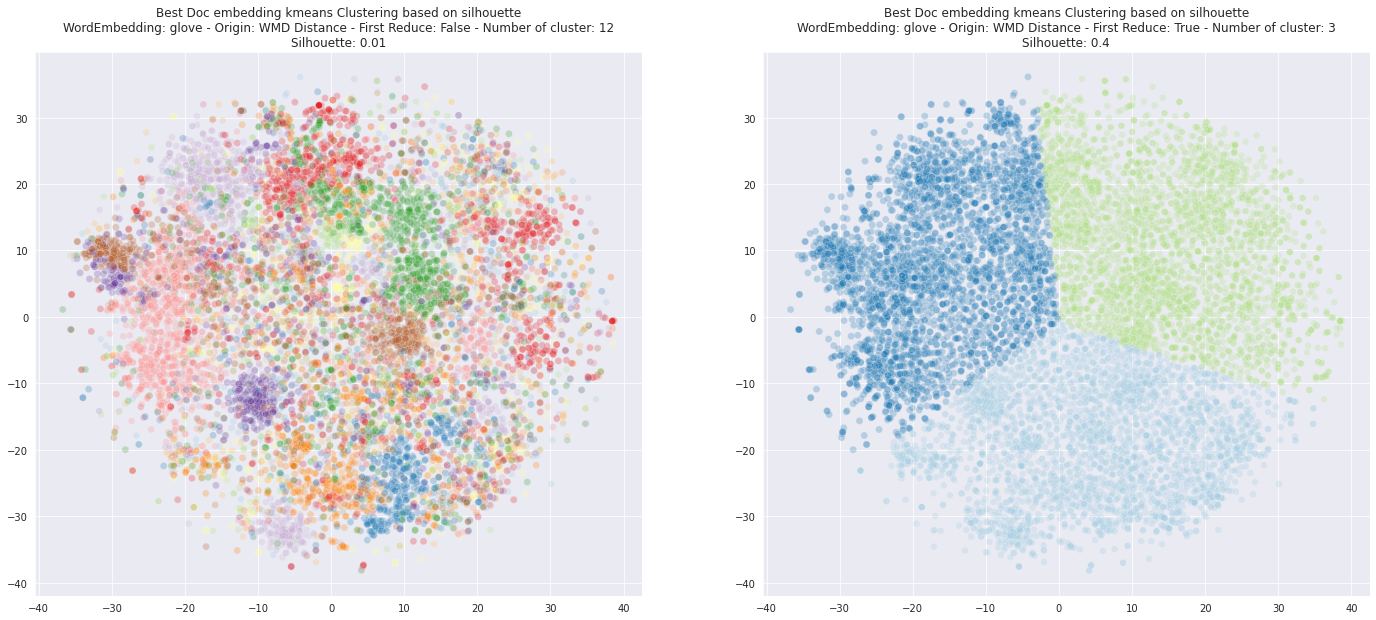

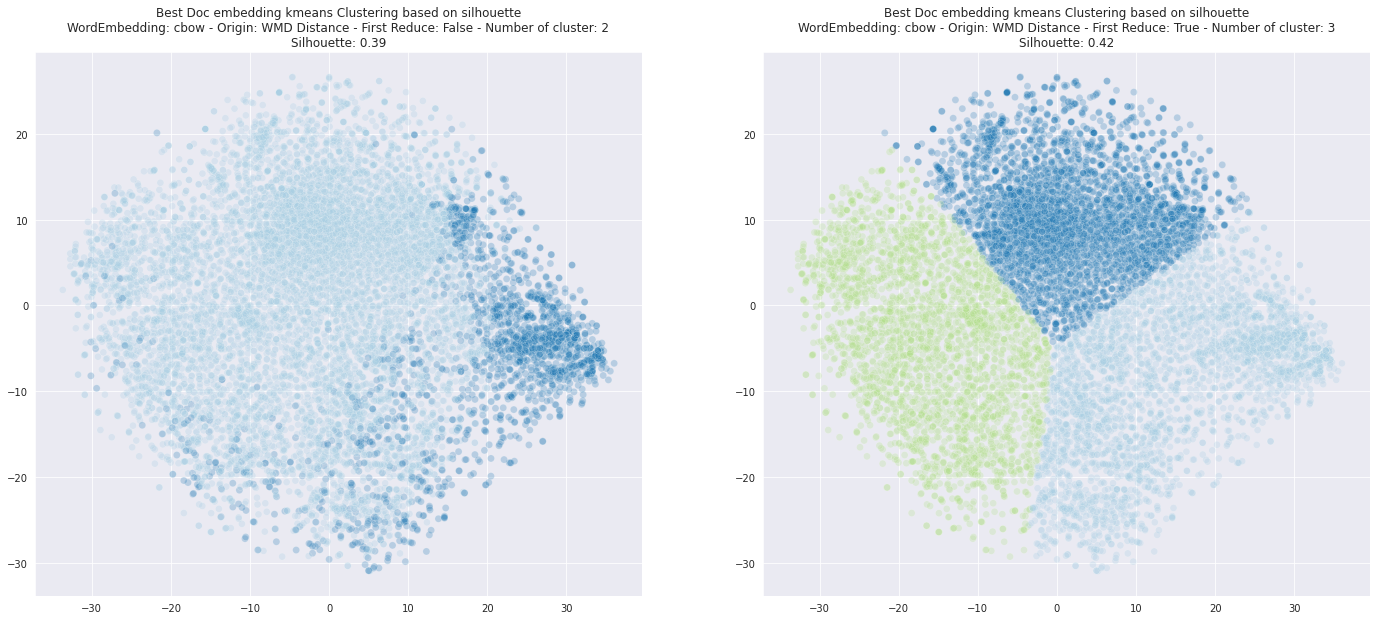

In [44]:
for modele in ["skipgram","glove","cbow"]:
    #Silhouette
    labels_silhouette, tsne_wmd_silhouette, silhouette_colors, silhouette_title = plot_kmeans(df_kmeans_wmd,dict_wmd_embedding,kmeans_metric="silhouette",first_reduce=False,modele=modele)
    labels_silhouette2, tsne_wmd_silhouette2, silhouette_colors2, silhouette_title2 = plot_kmeans(df_kmeans_wmd2,dict_wmd_embedding,kmeans_metric="silhouette",first_reduce=True,modele=modele)

    #Plot
    plt.figure(figsize = (50,10))
    if silhouette_title is not None:
        sns.scatterplot(tsne_wmd_silhouette[:,0],tsne_wmd_silhouette[:,1], s=50, c=silhouette_colors, alpha=0.25,ax=plt.subplot(1,4,3,title=silhouette_title))
    sns.scatterplot(tsne_wmd_silhouette2[:,0],tsne_wmd_silhouette2[:,1], s=50, c=silhouette_colors2, alpha=0.25,ax=plt.subplot(1,4,4,title=silhouette_title2))

    plt.show()

## Moyenne Embedding

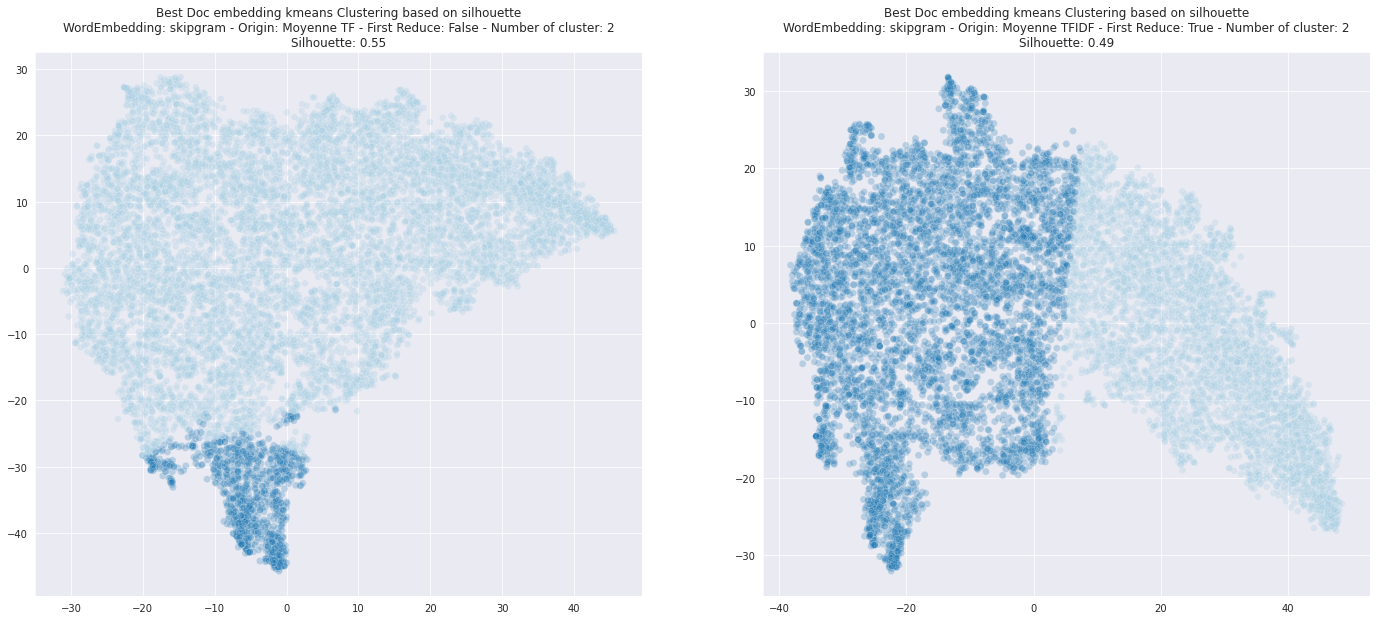

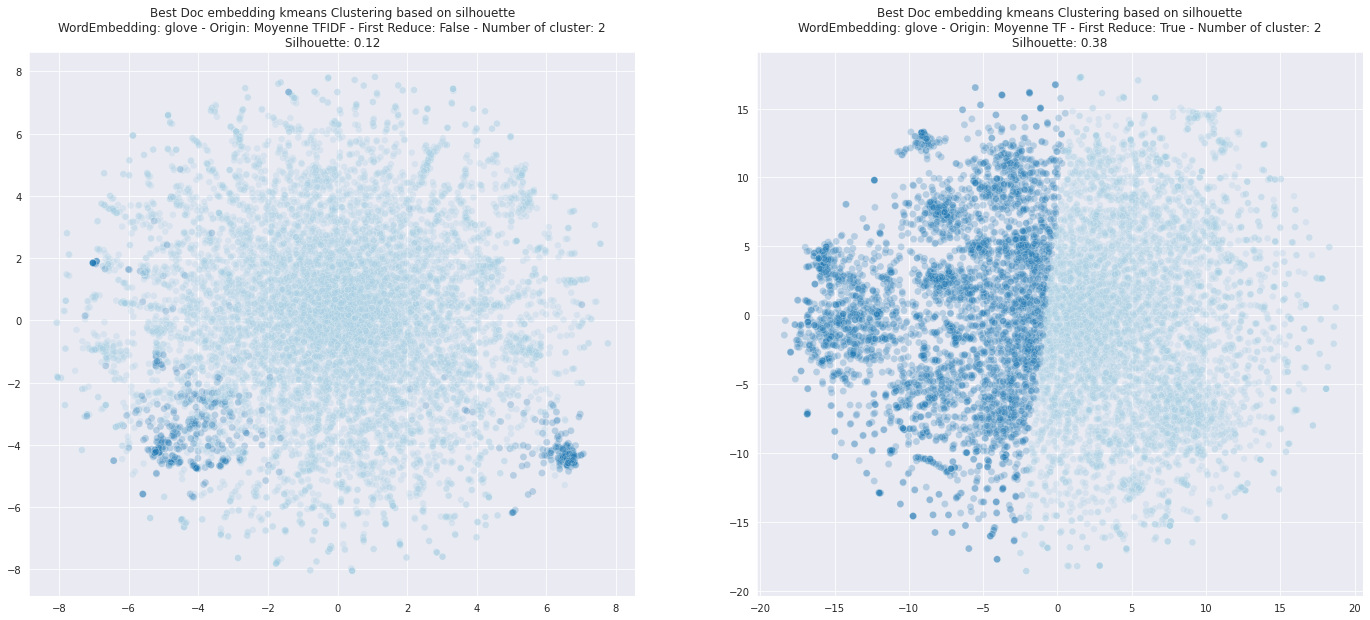

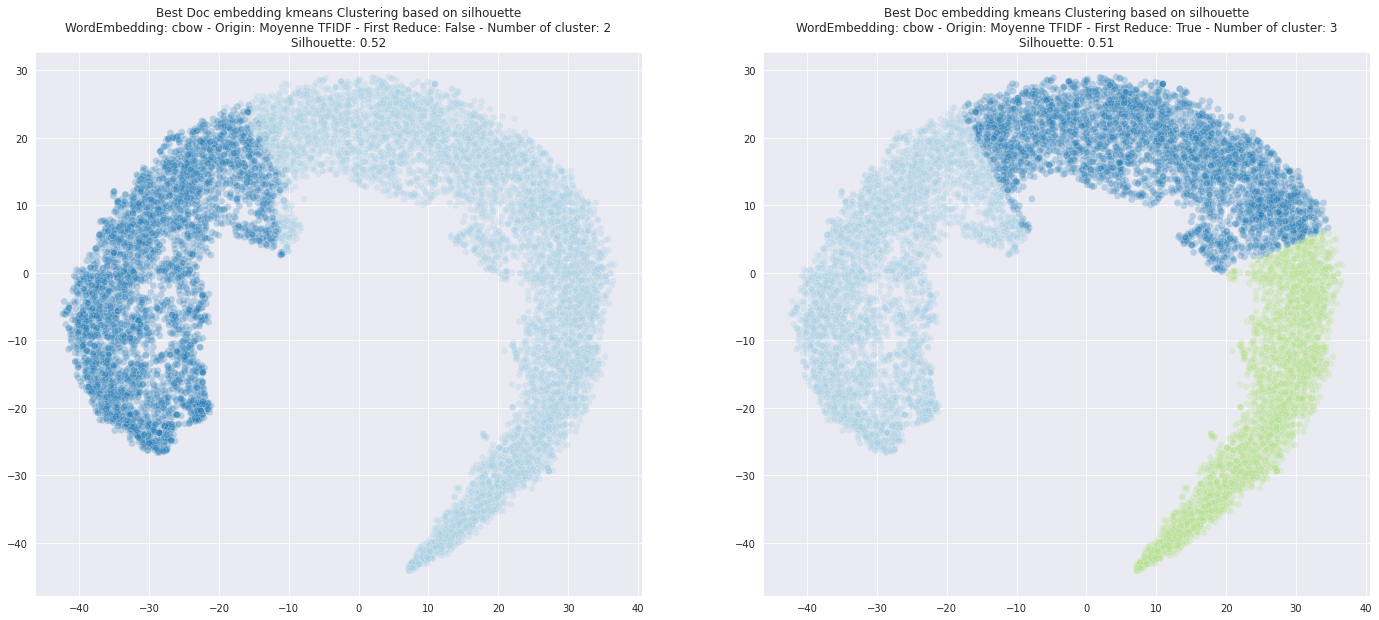

In [45]:
for modele in ["skipgram","glove","cbow"]:
    #Silhouette
    labels_silhouette, tsne_wmd_silhouette, silhouette_colors, silhouette_title = plot_kmeans(df_kmeans_moy,dict_moy_embedding,kmeans_metric="silhouette",first_reduce=False,modele=modele)
    labels_silhouette2, tsne_wmd_silhouette2, silhouette_colors2, silhouette_title2 = plot_kmeans(df_kmeans_moy2,dict_moy_embedding,kmeans_metric="silhouette",first_reduce=True,modele=modele)

    #Plot
    plt.figure(figsize = (50,10))
    if silhouette_title is not None:
        sns.scatterplot(tsne_wmd_silhouette[:,0],tsne_wmd_silhouette[:,1], s=50, c=silhouette_colors, alpha=0.25,ax=plt.subplot(1,4,3,title=silhouette_title))
    sns.scatterplot(tsne_wmd_silhouette2[:,0],tsne_wmd_silhouette2[:,1], s=50, c=silhouette_colors2, alpha=0.25,ax=plt.subplot(1,4,4,title=silhouette_title2))

    plt.show()